## Projet Commodities

**BOISDUR William, BERGERON Arthur, CONGNARD Thomas**

## Librairies

In [25]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

## Récupération des données

In [26]:
chemin = "Data_Commodities.xlsx"
data = pd.read_excel(chemin,header=1)
data

,Date,BCOMNG6 Index,BCOMNG3 Index,BCOMCC6 Index,BCOMCC3 Index
0,2013-01-02,24.7652,35.9070,220.8626,42.0876
1,2013-01-03,24.5039,35.4460,220.7660,42.0505
2,2013-01-04,25.0831,36.3788,217.3844,41.3821
3,2013-01-07,24.9559,36.1751,221.8287,42.2361
4,2013-01-08,24.6804,35.7033,216.7081,41.2707
...,...,...,...,...,...
2759,2023-12-15,17.7639,13.2443,429.8396,71.7766
2760,2023-12-18,17.6338,13.1017,432.1688,72.1870
2761,2023-12-19,16.9568,12.6575,434.4980,72.5631
2762,2023-12-20,16.8006,12.5149,435.5567,72.9051


## Création du dataframe et graphiques des cours des futurs

In [27]:
df=pd.DataFrame(index=data['Date'],columns=['Natural Gas 3m','Natural Gas 6m','Cocoa 3m','Cocoa 6m'])

df['Natural Gas 3m']=data['BCOMNG3 Index'].values
df['Natural Gas 6m']=data['BCOMNG6 Index'].values
df['Cocoa 3m']=data['BCOMCC3 Index'].values
df['Cocoa 6m']=data['BCOMCC6 Index'].values

df

,Natural Gas 3m,Natural Gas 6m,Cocoa 3m,Cocoa 6m
Date,,,,
2013-01-02,35.9070,24.7652,42.0876,220.8626
2013-01-03,35.4460,24.5039,42.0505,220.7660
2013-01-04,36.3788,25.0831,41.3821,217.3844
2013-01-07,36.1751,24.9559,42.2361,221.8287
2013-01-08,35.7033,24.6804,41.2707,216.7081
...,...,...,...,...
2023-12-15,13.2443,17.7639,71.7766,429.8396
2023-12-18,13.1017,17.6338,72.1870,432.1688
2023-12-19,12.6575,16.9568,72.5631,434.4980


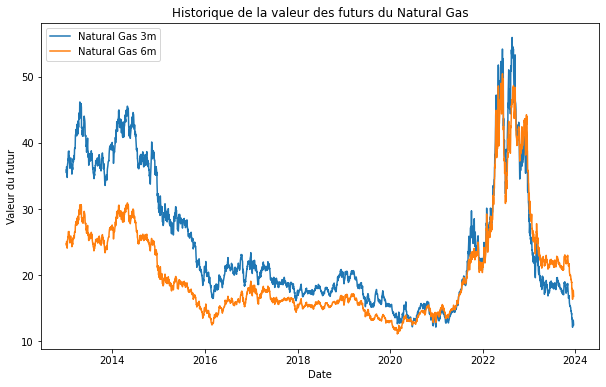

In [28]:
plt.figure(figsize=(10,6))
plt.plot(df['Natural Gas 3m'])
plt.plot(df['Natural Gas 6m'])

plt.title('Historique de la valeur des futurs du Natural Gas')
plt.legend(['Natural Gas 3m','Natural Gas 6m'])
plt.xlabel('Date')
plt.ylabel('Valeur du futur')

plt.show()

**Calcul des rendements quotidiens**

In [30]:
dfr=df.pct_change()
dfr=dfr.dropna()
dfcum=dfr.cumsum()
dfcum

,Natural Gas 3m,Natural Gas 6m,Cocoa 3m,Cocoa 6m
Date,,,,
2013-01-03,-0.012839,-0.010551,-0.000881,-0.000437
2013-01-04,0.013477,0.013086,-0.016777,-0.015755
2013-01-07,0.007878,0.008015,0.003860,0.004689
2013-01-08,-0.005164,-0.003025,-0.018997,-0.018394
2013-01-09,-0.031431,-0.027064,-0.015312,-0.014828
...,...,...,...,...
2023-12-15,-0.269518,0.141210,0.808184,0.908233
2023-12-18,-0.280285,0.133886,0.813901,0.913652
2023-12-19,-0.314189,0.095494,0.819111,0.919042


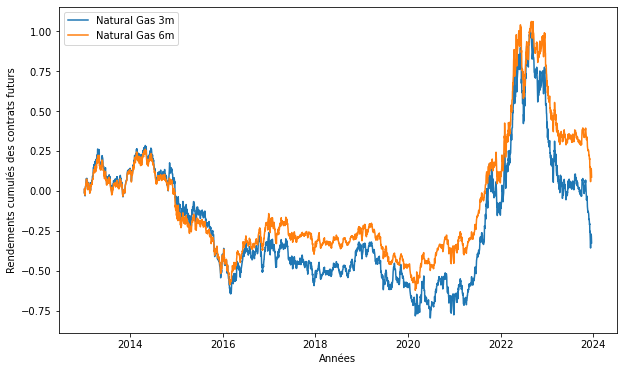

In [31]:
plt.figure(figsize=(10,6))
plt.plot(dfcum.iloc[:,:2])
plt.legend(dfcum.iloc[:,:2].columns)
plt.ylabel("Rendements cumulés des contrats futurs")
plt.xlabel("Années")
plt.show()

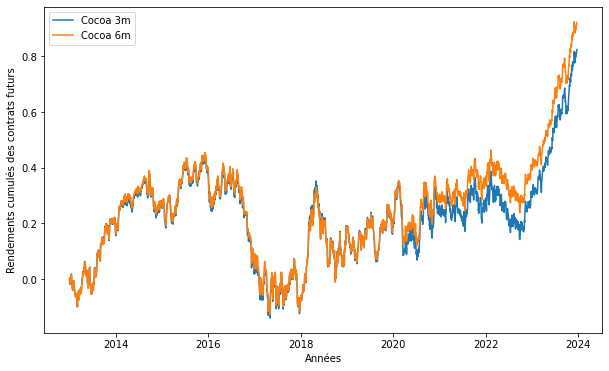

In [32]:
plt.figure(figsize=(10,6))
plt.plot(dfcum.iloc[:,2:])
plt.legend(dfcum.iloc[:,2:].columns)
plt.ylabel("Rendements cumulés des contrats futurs")
plt.xlabel("Années")
plt.show()

## Stratégie Natural Gas

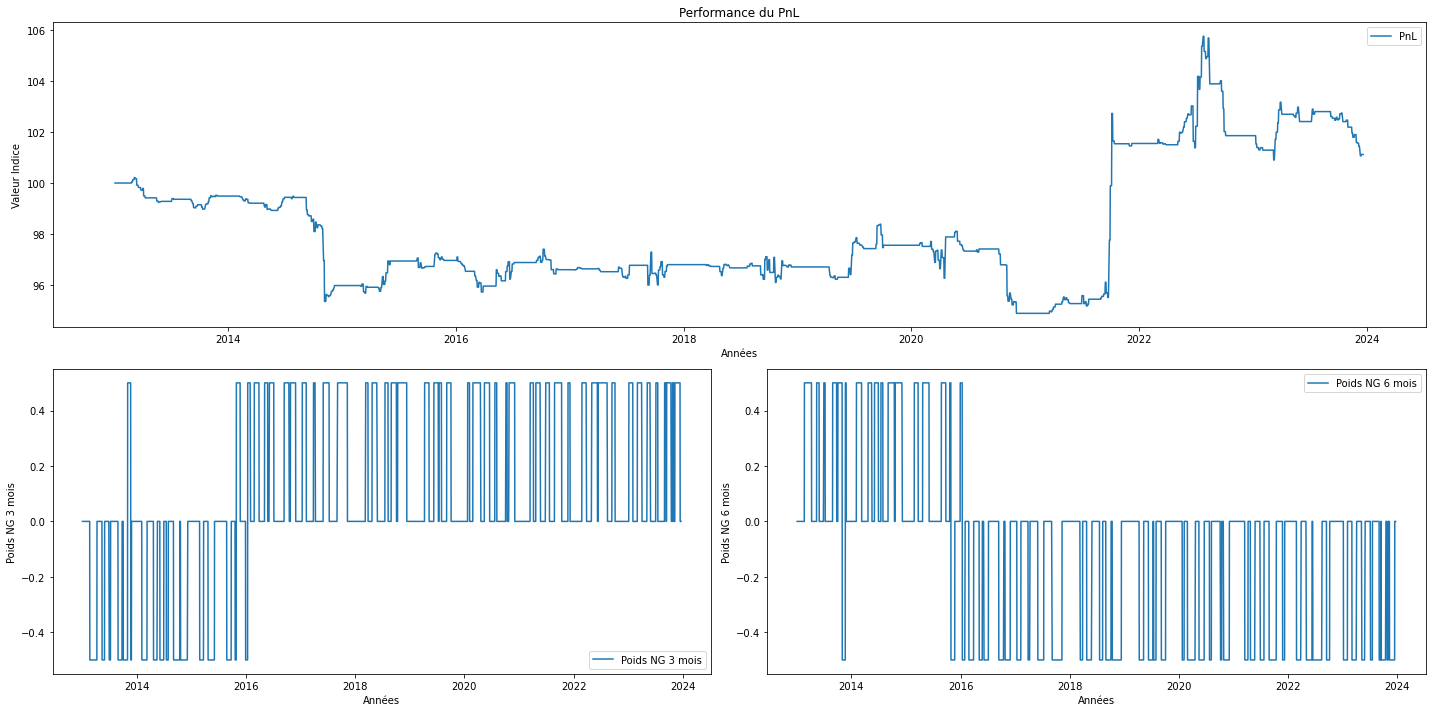

In [83]:

Historique_NG = pd.DataFrame(index=dfcum.index, columns=['PnL', 'Poids_NG_3m', 'Poids_NG_6m'])

Rebalancing_period = 3  # Période de rééquilibrage en jours
Expo_NG_max = 100
PnL = Expo_NG_max
Poids_NG_6m = 0
Poids_NG_3m = 0

window_size = 30  # Taille de la fenêtre pour le calcul de la volatilité du spread
volatility_threshold_percentile = 0.6  # Seuil de volatilité (75ème percentile)

# Calcul de la volatilité du spread sur toute la période
dfcum['Spread_Volatility'] = dfcum['Spread_NG'].rolling(window=window_size).std()

for jour in range(0, len(dfcum.index), Rebalancing_period):
    PnL += (Poids_NG_6m * dfr['Natural Gas 6m'].iloc[jour] + Poids_NG_3m * dfr['Natural Gas 3m'].iloc[jour]) * Expo_NG_max
    Historique_NG['PnL'].iloc[jour] = PnL
    
    # Utilisation de la volatilité du spread pour ajuster les poids
    if jour >= window_size:
        current_volatility = dfcum['Spread_Volatility'].iloc[jour]
        volatility_threshold = dfcum['Spread_Volatility'].iloc[max(0, jour - window_size):jour].quantile(volatility_threshold_percentile)
    else:
        current_volatility = float('inf')  # Pour les premières périodes, on ne prend pas de position
        volatility_threshold = float('inf')

    if current_volatility > volatility_threshold:
        spread = dfcum['Natural Gas 6m'].iloc[jour] - dfcum['Natural Gas 3m'].iloc[jour]
        if spread >= 0:
            Poids_NG_6m = -0.5
            Poids_NG_3m = 0.5
        else:
            Poids_NG_6m = 0.5
            Poids_NG_3m = -0.5
    else:
        Poids_NG_6m = 0  # Pas de position si la volatilité est basse
        Poids_NG_3m = 0

    Historique_NG['Poids_NG_6m'].iloc[jour] = Poids_NG_6m
    Historique_NG['Poids_NG_3m'].iloc[jour] = Poids_NG_3m

Historique_NG = Historique_NG.fillna(method='ffill')  # Remplir les valeurs manquantes par propagation
Historique_NG.index = pd.to_datetime(Historique_NG.index)

# Visualisation des résultats
plt.figure(figsize=(20, 10))

# Tracé du PnL
plt.subplot(2, 1, 1)  # 2 lignes, 1 colonne, position 1
plt.plot(Historique_NG['PnL'], label='PnL')
plt.ylabel("Valeur Indice")
plt.xlabel("Années")
plt.legend()
plt.title("Performance du PnL")

# Tracé des poids
plt.subplot(2, 2, 3)  # 2 lignes, 2 colonnes, position 3
plt.plot(Historique_NG['Poids_NG_3m'], label='Poids NG 3 mois')
plt.ylabel("Poids NG 3 mois")
plt.xlabel("Années")
plt.legend()

plt.subplot(2, 2, 4)  # 2 lignes, 2 colonnes, position 4
plt.plot(Historique_NG['Poids_NG_6m'], label='Poids NG 6 mois')
plt.ylabel("Poids NG 6 mois")
plt.xlabel("Années")
plt.legend()

plt.tight_layout()
plt.show()

In [72]:
spread_volatility

nan

## Calcul des statistiques

In [79]:
def MDD(L):
    if L[0]==0:
        Maxi=L[1]
    else :
        Maxi=L[0]
    MDD=0
    
    for i in range(1,len(L)):
        if L[i]>Maxi:
            Maxi=L[i]
        Drawdown=L[i]/Maxi-1
        if Drawdown<MDD:
            MDD=Drawdown
    return MDD

In [84]:
rdt_NG_2013=Historique_NG[Historique_NG.index.year==2013]
rdt_NG_2014=Historique_NG[Historique_NG.index.year==2014]
rdt_NG_2015=Historique_NG[Historique_NG.index.year==2015]
rdt_NG_2016=Historique_NG[Historique_NG.index.year==2016]
rdt_NG_2017=Historique_NG[Historique_NG.index.year==2017]
rdt_NG_2018=Historique_NG[Historique_NG.index.year==2018]
rdt_NG_2019=Historique_NG[Historique_NG.index.year==2019]
rdt_NG_2020=Historique_NG[Historique_NG.index.year==2020]
rdt_NG_2021=Historique_NG[Historique_NG.index.year==2021]
rdt_NG_2022=Historique_NG[Historique_NG.index.year==2022]
rdt_NG_2023=Historique_NG[Historique_NG.index.year==2023]

Histo_NG_rdt=[rdt_NG_2013,rdt_NG_2014,rdt_NG_2015,rdt_NG_2016,rdt_NG_2017,rdt_NG_2018,rdt_NG_2019,rdt_NG_2020,rdt_NG_2021,rdt_NG_2022,rdt_NG_2023]
for i in range(len(Histo_NG_rdt)):
    r=Histo_NG_rdt[i].iloc[-1,0]/Expo_NG_max-1
    vol=Histo_NG_rdt[i].iloc[:,0].std()
    print("----------------")
    print(f"Année : {i+2013}")
    print(f"Rendement annuel : {round(r*100,3)}%")
    print(f"Vol annualisée : {round(vol,3)}%")
    print(f"Ratio de Sharpe : {round(r*100/vol,3)}")
    print(f"Maximun Drawdown : {round(MDD(Histo_NG_rdt[i].iloc[:,0])*100,3)}%")

----------------
Année : 2013
Rendement annuel : -0.511%
Vol annualisée : 0.313%
Ratio de Sharpe : -1.634
Maximun Drawdown : -1.236%
----------------
Année : 2014
Rendement annuel : -4.02%
Vol annualisée : 1.266%
Ratio de Sharpe : -3.176
Maximun Drawdown : -4.154%
----------------
Année : 2015
Rendement annuel : -3.036%
Vol annualisée : 0.486%
Ratio de Sharpe : -6.252
Maximun Drawdown : -0.415%
----------------
Année : 2016
Rendement annuel : -3.4%
Vol annualisée : 0.373%
Ratio de Sharpe : -9.126
Maximun Drawdown : -1.416%
----------------
Année : 2017
Rendement annuel : -3.2%
Vol annualisée : 0.188%
Ratio de Sharpe : -16.984
Maximun Drawdown : -1.324%
----------------
Année : 2018
Rendement annuel : -3.291%
Vol annualisée : 0.174%
Ratio de Sharpe : -18.965
Maximun Drawdown : -1.04%
----------------
Année : 2019
Rendement annuel : -2.44%
Vol annualisée : 0.566%
Ratio de Sharpe : -4.31
Maximun Drawdown : -0.935%
----------------
Année : 2020
Rendement annuel : -5.111%
Vol annualisée : 0

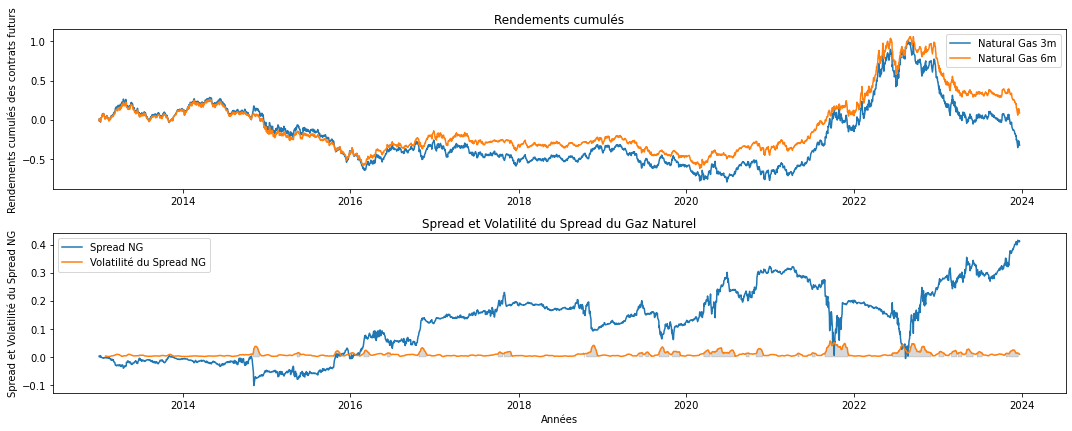

In [67]:
# Calcul du spread
dfcum['Spread_NG'] = dfcum['Natural Gas 6m'] - dfcum['Natural Gas 3m']

# Calcul de la volatilité du spread
window_size = 20  # Exemple : fenêtre de 20 jours
dfcum['Spread_Volatility'] = dfcum['Spread_NG'].rolling(window=window_size).std()

# Seuil de volatilité pour prendre une position
volatility_threshold = dfcum['Spread_Volatility'].quantile(0.75)  # Exemple : 75ème percentile

# Définir les positions (True pour prendre une position, False sinon)
dfcum['Position'] = dfcum['Spread_Volatility'] > volatility_threshold

# Visualisation
plt.figure(figsize=(15, 6))

plt.subplot(2, 1, 1)
plt.plot(dfcum[['Natural Gas 3m', 'Natural Gas 6m']])
plt.legend(['Natural Gas 3m', 'Natural Gas 6m'])
plt.ylabel("Rendements cumulés des contrats futurs")
plt.title("Rendements cumulés")

plt.subplot(2, 1, 2)
plt.plot(dfcum['Spread_NG'], label='Spread NG')
plt.plot(dfcum['Spread_Volatility'], label='Volatilité du Spread NG')
plt.fill_between(dfcum.index, 0, dfcum['Spread_Volatility'], where=dfcum['Position'], color='gray', alpha=0.3)
plt.legend()
plt.ylabel("Spread et Volatilité du Spread NG")
plt.title("Spread et Volatilité du Spread du Gaz Naturel")

plt.xlabel("Années")
plt.tight_layout()
plt.show()